<img src="https://s3.amazonaws.com/datascienceheroes.com/EDV/360_banner_python.png" width="400px">


# Escuela de Datos Vivos 

## LAB P.G.1.1: Introducción a los pipelines
Creado por Pablo Casas | https://escueladedatosvivos.ai    

Resuelto por Pablo Sotomayor

---

## Ejercicio

Cargar `income_estimation_sample` y limpiar los nulos de las variables `age` y `education`.

Variable a predecir: `income`.

1) Identificar las variables con nulos.

2) Imputar por la mediana la variable numérica.

3) Agregar la categoría "nulo" en las categóricas.

Nota: Usar exclusivamente pipelines.

4) Entrenar un random forest.

5) Generar las predicciones para train y para test.

6) Graficar la curva ROC para train y para test.


## Solución

In [389]:
# Librerías que utilizaremos

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import set_config
from pandas_profiling import ProfileReport
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer  # Requiere que la variable no tenga nulos
from funpymodeling.exploratory import freq_tbl, status, profiling_num, cat_vars, num_vars

set_config(display='diagram')    # Para visualizar el diagrama de transformación:

1) Carga de datos

In [390]:
data = pd.read_csv("../data/income_estimation_sample2.csv", sep=';')#, index_col=0)

print(f"Cantidad de registros: {data.shape[0]}")
print(f"Cantidad de variables: {data.shape[1]}")

Cantidad de registros: 4884
Cantidad de variables: 5


Inspeccionamos los datos elegiendo una muestra al azar

In [391]:
data.sample(5)

,marital_status,hours_per_week,age,education,income
2250,Married-civ-spouse,45,57.0,9th,<=50K
1661,Married-civ-spouse,40,51.0,Some-college,<=50K
672,Never-married,30,20.0,Some-college,<=50K
2264,Widowed,40,58.0,11th,<=50K
1974,Never-married,12,18.0,12th,<=50K


Revisamos el estado de las variables

In [392]:
status(data).sort_values(by=["type", "p_nan", "p_zeros", "unique"], ascending=False)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
3,education,5,0.001024,0,0.0,16,object
0,marital_status,0,0.000000,0,0.0,7,object
4,income,0,0.000000,0,0.0,2,object
1,hours_per_week,0,0.000000,0,0.0,77,int64
2,age,7,0.001433,0,0.0,69,float64


Tenemos 3 variables declaradas como categóricas y 2 declaradas como numéricas. El dataset no tiene valores ceros, pero tiene algunos valores nulos en las variables "education" (el 1% de las entradas) y "age" (el 1% delas entradas).

2) Para la variable numérica "age" imputamos los nulos usando la mediana. Utilizaremos la función Pipeline de la librería sklearn

In [393]:
num_transformer = Pipeline(
    steps=[('num_imputer', SimpleImputer(strategy='median'))])

num_transformer

Pipeline(steps=[('num_imputer', SimpleImputer(strategy='median'))])

3) Para la variable categórica "education" agregamos la categoría "nulo" y hacemos one-hot encoder de los datos

In [394]:
cat_transformer = Pipeline(
    steps=[('cat_imputer', SimpleImputer(strategy='constant', fill_value='nulo')),
          ('ohe', OneHotEncoder())])

cat_transformer

Pipeline(steps=[('cat_imputer',
                 SimpleImputer(fill_value='nulo', strategy='constant')),
                ('ohe', OneHotEncoder())])

4) Entrenamos un modelo RandomForest para clasificación

Separamos los datos en TR y TS

In [395]:
data_x = data.drop('income', axis=1)
data_y = data['income']

x_tr, x_ts, y_tr, y_ts = train_test_split(data_x, 
                                          data_y, 
                                          test_size=0.3, 
                                          random_state=0)

Juntamos ambos transformer (los Pipelines) en un ColumnTransformer, lo cual retorna otro transformer

In [396]:
all_transformer = ColumnTransformer(
    transformers=[
        ('num_t', num_transformer, num_vars(x_tr)),
        ('cat_t', cat_transformer, cat_vars(x_tr))])

all_transformer

ColumnTransformer(transformers=[('num_t',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['hours_per_week', 'age'], dtype='object')),
                                ('cat_t',
                                 Pipeline(steps=[('cat_imputer',
                                                  SimpleImputer(fill_value='nulo',
                                                                strategy='constant')),
                                                 ('ohe', OneHotEncoder())]),
                                 Index(['marital_status', 'education'], dtype='object'))])

Creamos otro transformer (Pipeline) que toma las transformaciones y le agrega un modelo predictivo

In [397]:
pipe_rf = Pipeline(steps=[('all_transformer', all_transformer),
                          ('model_rf', RandomForestClassifier(min_samples_leaf=25, 
                                                              max_depth = 5,
                                                              max_features=5,
                                                              min_samples_split=50,
                                                              n_estimators=100,
                                                              random_state=1))]) 

pipe_rf

Pipeline(steps=[('all_transformer',
                 ColumnTransformer(transformers=[('num_t',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['hours_per_week', 'age'], dtype='object')),
                                                 ('cat_t',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='nulo',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  Index(['marital_status', 'education'], dtype='object'))])),
                ('model_rf',
                 RandomForestClassifier(max_depth=5, max_features=5,
                                        min_samples_leaf=25,
                                        min_samples_split=50,
                                        random_state=1))])

5) Generamos las predicciones para TR y TS

Entrenamos al modelo

In [398]:
pipe_rf.fit(x_tr, y_tr)

Pipeline(steps=[('all_transformer',
                 ColumnTransformer(transformers=[('num_t',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['hours_per_week', 'age'], dtype='object')),
                                                 ('cat_t',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='nulo',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  Index(['marital_status', 'education'], dtype='object'))])),
                ('model_rf',
                 RandomForestClassifier(max_depth=5, max_features=5,
                                        min_samples_leaf=25,
                                        min_samples_split=50,
                                        random_state=1))])

Hacemos las predicciones

In [399]:
pipe_rf.predict_proba(x_ts)

array([[0.81210474, 0.18789526],
       [0.88815731, 0.11184269],
       [0.74568701, 0.25431299],
       ...,
       [0.90087339, 0.09912661],
       [0.4763271 , 0.5236729 ],
       [0.8214794 , 0.1785206 ]])

6) Graficamos la curva ROC para TR y TS

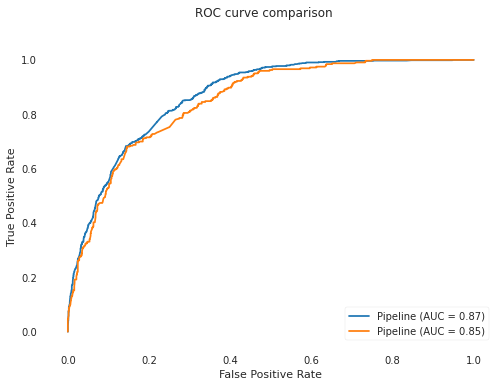

In [400]:
svc_disp = plot_roc_curve(pipe_rf, x_tr, y_tr)
rfc_disp = plot_roc_curve(pipe_rf, x_ts, y_ts, ax=svc_disp.ax_)
rfc_disp.figure_.suptitle("ROC curve comparison")

plt.show()

El modelo entrenada tiene un buen acuerdo en sus predicciones para los datos TR y TS.